## Topic Modeling IMDB Movie Reviews
### DS 7337 - Natural Laguage Processing - FInal Project
#### George C. Sturrock
##### April 14, 2019
##### Resources
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
#### Import Libraries

In [1]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request; ("urllib:", request.__version__)
import warnings
warnings.filterwarnings('ignore')
from time import sleep

#Web Scraping
import bs4; print("BeatifulSoup:", bs4.__version__)
from bs4 import BeautifulSoup
import json; print("json:", json.__version__)

#Python Basics
import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
from matplotlib import pyplot as plt
import seaborn as sns;
import string

#scikit learn
from sklearn import metrics
from sklearn.feature_extraction import stop_words
#print(stop_words.ENGLISH_STOP_WORDS)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV

import pattern; print("Pattern Version:", pattern.__version__)
from pattern.en import tag, parse, Sentence, parsetree, suggest, lemma, wordnet
from pattern.vector import Document, Model, TFIDF, TF, words, stem, PORTER, LEMMA

#pyLDAvis
import pyLDAvis; print("pyLDAvis Versoin:", pyLDAvis.__version__)
import pyLDAvis.sklearn

Platform: Windows-10-10.0.14393-SP0
Python: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Requests: 2.21.0
BeatifulSoup: 4.7.1
json: 2.0.9
Numpy Version: 1.16.2
Pandas Version: 0.24.2
Pattern Version: 3.6
pyLDAvis Versoin: 2.1.2


### Data Acquisition
The first three films in the "Rocky" series will be utilized to collect reviews for noun phrase chunking.  Link to the main user review page for each of the three movies are shown below.  To assure both positive and negative reviews are collected, there are two links per movie.  One is sorted descending by user rating.  The other is sorted ascending by user rating.  Both links have "spoiler alert" messages suppressed as these reviews are often more akin to a summarization of the movie plot instead of a true review.  

In [2]:
#Rocky movie list.  Two links for each movie to assure positive and negative reviews are captured.  
#Sort descending by Review Rating.  Sort ascending by Review Rating.

#Rocky
rockyDict = {"aRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0", 
         "dRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0", 
#Rocky 2
         "dRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0",
#Rocky 3
         "dRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0"
            }

rockyKeys = rockyDict.keys()

#### Web Scraping IMDB Movie Review Titles
The individual links to the user reviews are collected below.  A get request uses each of the links in the "rockyDict" python dictionary.  The response is parsed by Beautiful Soup to find the individual links to each individual review.  The review URLs along with the movie name are written to a dataframe named dfRockyReviews.

In [3]:
reviewUrls = list()
dfRockyReviews = pd.DataFrame(columns = ['Movie', 'ReviewURL'])

for r in rockyKeys:
    #print(r, rockyDict[r])
    response = requests.get(rockyDict[r])
    soup = BeautifulSoup(response.text, 'html.parser')
    rUrls = ["http:" + s.attrs['href'] for s in soup.find_all(href = True, class_ = 'title')]
    reviewUrls = reviewUrls + rUrls
    for u in rUrls:
        dfRockyReviews = dfRockyReviews.append({'Movie':r[1:], 'ReviewURL':u}, ignore_index=True)

A sample of the dfRockyReviews dataframe is shown below.

In [4]:
dfRockyReviews[0:5]

,Movie,ReviewURL
0,Rocky,http:/review/rw4247059/
1,Rocky,http:/review/rw0149538/
2,Rocky,http:/review/rw0149534/
3,Rocky,http:/review/rw3451942/
4,Rocky,http:/review/rw2406266/


#### Web Scraping IMDB Movie Review Details
The individual review URLs collected above will be requested and parsed to retrieve key qualitative and categorical data about each review along with the review text itself.  These details are stored in a new dataframe named dfReviewDetails.  The first five records are this dataframe are shown below.

In [5]:
dfReviewDetails = pd.DataFrame(columns=['Movie', 'ReviewUrl', 'ReviewDate', 'ReviewTitle', 'Review', 'Rating', 
                                        'Language'])
counter = 0

for r in reviewUrls:
    fullUrl = "https://www.imdb.com" + r[5:]
    response2 = requests.get(fullUrl)
    soup2 = BeautifulSoup(response2.text, 'html.parser')
    rjson = soup2.find('script', type = 'application/ld+json').text
    rjson = json.loads(rjson)
    
    try:
        rating = rjson['reviewRating']['ratingValue']
    except Exception as e:
        #print("No User Rating")
        rating = 5
        
    ### Add stemming logic to review body
    
    dfReviewDetails = dfReviewDetails.append({'Movie':dfRockyReviews.Movie[counter], 'ReviewUrl':r, 
                                              'ReviewDate':rjson['dateCreated'], 'ReviewTitle':rjson['name'], 
                                              'Review':rjson['reviewBody'], 'Rating':rating, 
                                              'Language':rjson['inLanguage']}, ignore_index=True)
    counter += 1

dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language
0,Rocky,http:/review/rw4247059/,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English
1,Rocky,http:/review/rw0149538/,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English
2,Rocky,http:/review/rw0149534/,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English
3,Rocky,http:/review/rw3451942/,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English
4,Rocky,http:/review/rw2406266/,2011-03-30,I can't believe the script was made into a mov...,I was told by many that Rocky is a beautiful m...,3,English


The bar plot below shows movie review ratings for the reviews collected in the prior step. The original "Rocky" is widely considered the best of the "Rocky" series.  It won multiple Oscars and introduced "Steady-Cam" technology to the movie world.  However, the sample of user reviews collected tell a different story.  

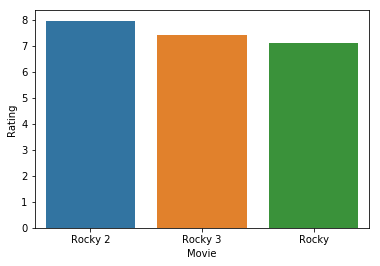

In [6]:
plotdf = dfReviewDetails.sort_values(by=['ReviewDate'])
plotdf.Rating = plotdf.Rating.astype('int64')
plotdf.ReviewDate = pd.to_datetime(plotdf.ReviewDate)
plotdf = plotdf.groupby(['Movie']).mean().reset_index()
sns.barplot(x='Movie', y='Rating', data=plotdf.sort_values(by=['Rating'], ascending=False))

### Data Engineering
#### Create Additional Features for Topic Modeling

In [7]:
nerList = []
hypernymList = []
lemmaList = []

sw = stop_words.ENGLISH_STOP_WORDS
table = str.maketrans('', '', string.punctuation)

#tx = tag(dfReviewDetails.Review[2], tokenize=True)

#Create Lemmatize, NER, Hypernyms version of each review for topic modeling
for dfr in dfReviewDetails.Review:
    tlist = []
    poslist = []
    nlist = []
    hlist = []
    t1 = tag(dfr, tokenize=True)
    for t, pos in t1:
        if t not in sw and t not in string.punctuation:
            if pos != "NNPS" and pos != "NNP":
                tlist.append(lemma(t))
                poslist.append(pos)
            else:
                nlist.append(t)
                tlist.append(t)
                poslist.append(pos)
            if pos.startswith("N") or pos.startswith("V"):
                s = wordnet.synsets(t, pos = pos)
                try:
                    sout = str(s[0].hypernyms(recursive=False, depth=None))[9:]
                    sout = sout.split('.')[0]
                    hlist.append(sout)
                except Exception as e:
                    #print(t2, p2, e) 
                    pass
                
    lt = " ".join(l for l in tlist)
    nl = " ".join(n for n in nlist)
    hl = " ".join(h for h in hlist)
    lemmaList.append(lt)
    nerList.append(nl)
    hypernymList.append(hl)


C:\Anaconda\lib\site-packages\pattern\text\__init__.py:625: DeprecationWarning: generator '_read' raised StopIteration
  dict.update(self, (x.split(" ")[:2] for x in _read(self._path) if len(x.split(" ")) > 1))
C:\Anaconda\lib\site-packages\pattern\text\__init__.py:959: DeprecationWarning: generator '_read' raised StopIteration
  for x in _read(self.path):
C:\Anaconda\lib\site-packages\pattern\text\__init__.py:2127: DeprecationWarning: generator '_read' raised StopIteration
  for v in _read(self._path):


In [8]:
dfReviewDetails['nerReview'] = nerList
dfReviewDetails['lemmaReview'] = lemmaList
dfReviewDetails['hyperReview'] = hypernymList

In [9]:
dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language,nerReview,lemmaReview,hyperReview
0,Rocky,http:/review/rw4247059/,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English,,the fight scene pathetic act laughable rubbish,military_action area activity waste
1,Rocky,http:/review/rw0149538/,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English,Hollywood,i remember initial outrage piece sentimental s...,anger part feed product remark inability be...
2,Rocky,http:/review/rw0149534/,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English,Apollo Creed Aki Kaurismaki Rocky VI,grubby late-night fare achieve way succes prim...,agenda succeed property happening message musi...
3,Rocky,http:/review/rw3451942/,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English,Rocky Stallone Rocky Rocky God Burgess Meredit...,i be go come say i do be like film i know go h...,travel express desire product emotion fact...
4,Rocky,http:/review/rw2406266/,2011-03-30,I can't believe the script was made into a mov...,I was told by many that Rocky is a beautiful m...,3,English,Rocky Stalone,i tell Rocky beautiful movie i watch i do the ...,express product product move rate imaginary_...


In [10]:
dfReviewDetails.to_pickle("./dfReviewDetailsPlus.pkl")

In [11]:
print(len(hypernymList))
print(len(lemmaList))
print(len(nerList))

150
150
150


#### Vectorize Reviews

In [12]:
tfidfVectorizer = TfidfVectorizer(max_df=1, min_df=0, stop_words='english', use_idf=True, ngram_range=(1,3))
countVectorizer = CountVectorizer(analyzer='word', min_df=9, stop_words='english', lowercase=True)

In [13]:
tfidfMatrix = tfidfVectorizer.fit_transform(dfReviewDetails.Review)
tfidfMatrix.shape

(150, 29042)

In [14]:
cvReview = countVectorizer.fit_transform(dfReviewDetails.Review)
cvReview.shape

(150, 254)

In [224]:
cvNer = countVectorizer.fit_transform(dfReviewDetails.nerReview)
cvNer.shape

(150, 29)

In [225]:
cvLemma = countVectorizer.fit_transform(dfReviewDetails.lemmaReview)
cvLemma.shape

(150, 273)

In [226]:
cvHyper = countVectorizer.fit_transform(dfReviewDetails.hyperReview)
cvHyper.shape

(150, 167)

In [227]:
#sparceness
cvDense = cvReview.todense()
print("Sparseness: ", ((cvDense > 0).sum()/cvDense.size)*100, "%")

Sparseness:  13.40959409594096 %


### Topic Modelling

##### LDA Model GridSearchCV

In [15]:
lda = LatentDirichletAllocation()

parmGrid = {'n_components': [3, 5, 7, 9], 
            'learning_method': ['online'], 
            'random_state': [2019], 
            'learning_decay': [0.5, 0.7, 0.9], 
            'max_iter': [5, 10]}

ldaGrid = GridSearchCV(lda, param_grid=parmGrid)

In [16]:
def modelTopic(matrixIn):
    clf = ldaGrid.fit(matrixIn)
    print(clf.best_estimator_)
    print(clf.best_params_)
    return clf

#### LDA for Full Reviews

In [18]:
ldaClf = modelTopic(cvReview)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
{'learning_decay': 0.9, 'learning_method': 'online', 'max_iter': 5, 'n_components': 3, 'random_state': 2019}


In [19]:
#ldaReview = ldaClf.best_estimator_.fit_transform(cvReview)
ldaReview = ldaClf.best_estimator_.fit_transform(cvReview)
print(ldaClf.score(cvReview))

-42110.14555224803


In [20]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvReview, countVectorizer, mds='tsne')
#panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvHyper, countVectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
0      -632.045471 -384.325073       1        1  82.026204
1     -1209.665405  212.164124       2        1  10.225152
2     -1437.453247 -586.322510       3        1   7.748644, topic_info=    Category        Freq          Term       Total  loglift  logprob
145  Default  221.000000         movie  221.000000  30.0000  30.0000
113  Default  110.000000          just  110.000000  29.0000  29.0000
80   Default  230.000000          film  230.000000  28.0000  28.0000
208  Default  154.000000      stallone  154.000000  27.0000  27.0000
120  Default   89.000000          like   89.000000  26.0000  26.0000
211  Default  117.000000         story  117.000000  25.0000  25.0000
76   Default  113.000000         fight  113.000000  24.0000  24.0000
222  Default   86.000000          time   86.000000  23.0000  23.0000
24   Default   57.000000        boxing   57.000000  22.0000  22.0000
19   Default   47.000000          best   47.000000  21.0000  21.0000
56   Default   42.000000           don   42.000000  20.0000  20.0000
60   Default   48.000000           end   48.000000  19.0000  19.0000
62   Default   31.000000  entertaining   31.000000  18.0000  18.0000
146  Default   73.000000        movies   73.000000  17.0000  17.0000
34   Default   71.000000     character   71.000000  16.0000  16.0000
93   Default  145.000000          good  145.000000  15.0000  15.0000
10   Default  112.000000        apollo  112.000000  14.0000  14.0000
7    Default   55.000000        adrian   55.000000  13.0000  13.0000
141  Default   45.000000      meredith   45.000000  12.0000  12.0000
97   Default   23.000000           guy   23.000000  11.0000  11.0000
237  Default   26.000000      watching   26.000000  10.0000  10.0000
177  Default   68.000000        really   68.000000   9.0000   9.0000
53   Default   36.000000          does   36.000000   8.0000   8.0000
65   Default   43.000000           eye   43.000000   7.0000   7.0000
57   Default   22.000000         drama   22.000000   6.0000   6.0000
131  Default   38.000000          love   38.000000   5.0000   5.0000
99   Default   30.000000         heart   30.000000   4.0000   4.0000
31   Default   34.000000      champion   34.000000   3.0000   3.0000
119  Default   61.000000          life   61.000000   2.0000   2.0000
184  Default  760.000000         rocky  760.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
232   Topic3    3.411894            ve   16.353242   0.9905  -5.2196
45    Topic3    1.967107           day    9.802357   0.9516  -5.7703
32    Topic3    3.523212        chance   18.877589   0.8791  -5.1875
19    Topic3    8.881875          best   47.744527   0.8758  -4.2629
186   Topic3    1.489368         round    8.088732   0.8655  -6.0485
48    Topic3    2.648187          didn   14.650482   0.8471  -5.4730
248   Topic3    4.448398         world   25.230490   0.8221  -4.9543
24    Topic3    9.274163        boxing   57.532590   0.7325  -4.2197
53    Topic3    5.446951          does   36.940379   0.6434  -4.7518
208   Topic3   15.554022      stallone  154.519450   0.2617  -3.7026
80    Topic3   16.887940          film  230.285045  -0.0551  -3.6203
211   Topic3   10.884378         story  117.501496   0.1785  -4.0596
31    Topic3    4.886326      champion   34.031795   0.6168  -4.8605
7     Topic3    5.819718        adrian   55.965530   0.2942  -4.6856
76    Topic3    8.211071         fight  113.406765  -0.0678  -4.3414
60    Topic3    5.247265           end   48.498557   0.3338  -4.7892
75    Topic3    4.015207         feels   27.682212   0.6270  -5.0568
86    Topic3    4.219935          gets   31.104499   0.5601  -5.0071
197   Topic3    4.093812        sequel   30.587613   0.5465  -5.0374
184   Topic3   14.736781         rocky  760.588960  -1.3861  -3.7565
10    Topic3    6.427153        apollo  112.035927  -0.3006  -4.5864
131  

In [216]:
ldaGrid.fit(cvReview)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_topics': [3, 5, 7, 9], 'learning_method': ['online'], 'random_state': [2019], 'learning_decay': [0.5, 0.7, 0.9], 'max_iter': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [217]:
print("Best Estimator:", ldaGrid.best_estimator_)
print(ldaGrid.best_params_)

Best Estimator: LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=3, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
{'learning_decay': 0.9, 'learning_method': 'online', 'max_iter': 5, 'n_topics': 3, 'random_state': 2019}


##### Full Review Model Scoring

In [207]:
ldaTest = ldaGrid.best_estimator_.fit_transform(cvReview)
print("Log Likelihood:", ldaGrid.best_estimator_.score(cvReview))

Log Likelihood: -44264.03007073572


In [218]:
## Original trained model
#
#lda = LatentDirichletAllocation(n_topics=10, max_iter=5, learning_method='online', random_state=2019, batch_size=120, 
#                               evaluate_every=-1, n_jobs=-1)
#
#ldaFit = lda.fit_transform(cvMatrix)
ldaBest = LatentDirichletAllocation(n_topics=3, max_iter=5, learning_method='online', learning_decay=0.9, 
                                    random_state=2019, evaluate_every=-1, n_jobs=-1)
ldaBestFit = ldaBest.fit_transform(cvReview)

In [219]:
print("Log Likelihood:", ldaBest.score(cvReview))
print("Perplexity:", ldaBest.perplexity(cvReview))

Log Likelihood: -44257.87710120041
Perplexity: 187.40711341898282


##### LDA Model Scoring

Original Model

print("Log Likelihood:", lda.score(cvMatrix))

print("Perplexity:", lda.perplexity(cvMatrix))

Log Likelihood: -65854.02334362216

Perplexity: 456.28047756163363

##### pyLDAvis Plotting

In [220]:
pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(lda, cvMatrix, countVectorizer, mds='tsne')
panel = pyLDAvis.sklearn.prepare(ldaBest, cvReview, countVectorizer, mds='tsne')
panel

AssertionError: Term frequencies and vocabulary are of different sizes, 271 != 167.

#### LDA for Named Entity Recognition